In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Ref: https://chatgpt.com/g/g-p-68eeaa4162b48191a6ab8b31241aee84-evolution-of-trust-simulation/c/68ec0088-5e20-8328-9eb2-6609cd7e5720

In [2]:
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [3]:
# T>R>P>S and 2R>T+S
# Typical example: T=5,R=3,P=1,S=0 (but keep it symbolic).

In [4]:
# -----------------------------
# PAYOFF MATRIX
# -----------------------------
# Payoffs for (player, opponent)
# R = Reward (mutual cooperation)
# T = Temptation (you defect, they cooperate)
# P = Punishment (mutual defection)
# S = Sucker (you cooperate, they defect)
R, T, P, S = 3, 5, 1, 0
PAYOFFS = {
    ('C', 'C'): (R, R),
    ('C', 'D'): (S, T),
    ('D', 'C'): (T, S),
    ('D', 'D'): (P, P)
}

In [5]:
# -----------------------------
# STRATEGY DEFINITIONS
# -----------------------------
class Strategy:
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.history = []

    def move(self, opponent_history):
        raise NotImplementedError


class Cooperator(Strategy):
    def __init__(self): super().__init__("Cooperator")
    def move(self, opponent_history): return 'C'


class Cheater(Strategy):
    def __init__(self): super().__init__("Cheater")
    def move(self, opponent_history): return 'D'


class Copycat(Strategy):
    def __init__(self): super().__init__("Copycat")
    def move(self, opponent_history):
        return 'C' if not opponent_history else opponent_history[-1]


class Grudger(Strategy):
    def __init__(self):
        super().__init__("Grudger")
        self.grudge = False
    def reset(self):
        super().reset(); self.grudge = False
    def move(self, opponent_history):
        if 'D' in opponent_history:
            self.grudge = True
        return 'D' if self.grudge else 'C'


class Detective(Strategy):
    def __init__(self):
        super().__init__("Detective")
        self.probe_moves = ['D', 'C', 'C', 'D']
    def reset(self):
        super().reset(); self.phase = "probe"
    def move(self, opponent_history):
        if len(self.history) < 4:
            return self.probe_moves[len(self.history)]
        if 'D' not in opponent_history:
            return 'D'
        else:
            return opponent_history[-1]


class Copykitten(Strategy):
    def __init__(self): super().__init__("Copykitten")
    def move(self, opponent_history):
        if len(opponent_history) < 2:
            return 'C'
        if opponent_history[-1] == 'D' and opponent_history[-2] == 'D':
            return 'D'
        return 'C'

In [6]:
# -----------------------------
# GAME MECHANICS
# -----------------------------
def play_round(p1, p2, noise=0.0):
    m1 = p1.move(p2.history)
    m2 = p2.move(p1.history)

    # Noise: flip action with small prob
    if random.random() < noise: m1 = 'D' if m1 == 'C' else 'C'
    if random.random() < noise: m2 = 'D' if m2 == 'C' else 'C'

    p1.history.append(m1)
    p2.history.append(m2)

    return PAYOFFS[(m1, m2)]


def play_match(p1, p2, rounds=50, noise=0.0):
    p1.reset(); p2.reset()
    total1 = total2 = 0
    for _ in range(rounds):
        pay1, pay2 = play_round(p1, p2, noise)
        total1 += pay1
        total2 += pay2
    return total1 / rounds, total2 / rounds


def tournament(strategies, rounds=50, noise=0.0):
    n = len(strategies)
    payoff_matrix = np.zeros((n, n))
    for i, s1 in enumerate(strategies):
        for j, s2 in enumerate(strategies):
            avg1, avg2 = play_match(s1, s2, rounds, noise)
            payoff_matrix[i, j] = avg1
    return payoff_matrix

In [7]:
# -----------------------------
# EVOLUTIONARY DYNAMICS
# -----------------------------
def evolve(strategies, generations=50, noise=0.05, rounds=50, initial_freq=None):
    names = [s.name for s in strategies]
    n = len(strategies)

    # Initialize frequencies
    if initial_freq is None:
        freqs = np.ones(n) / n
    else:
        freqs = np.array(initial_freq) / sum(initial_freq)

    history = [freqs.copy()]

    for g in range(generations):
        payoff_matrix = tournament(strategies, rounds, noise)
        avg_payoffs = payoff_matrix.dot(freqs)
        mean_fitness = np.dot(freqs, avg_payoffs)

        # Replicator equation
        freqs = freqs * (avg_payoffs / mean_fitness)
        freqs /= freqs.sum()  # normalize to sum=1
        history.append(freqs.copy())

    return np.array(history), names



Typical Behavior
- If noise = 0, Copycat often dominates (perfect reciprocity).
- With small noise (≈ 0.05), Copykitten often wins — it’s forgiving.
- If noise is high or discounting matters less, Grudger and Cheater may reappear.

# Run Simulation

## noise=0

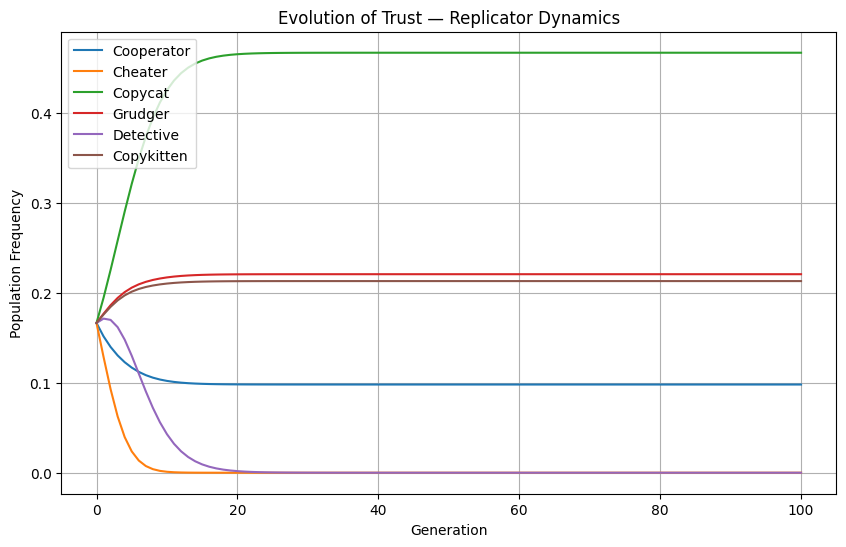

In [8]:
# -----------------------------
# RUN THE EVOLUTION SIMULATION
# -----------------------------
if __name__ == "__main__":
    strategies = [
        Cooperator(),
        Cheater(),
        Copycat(),
        Grudger(),
        Detective(),
        Copykitten()
    ]

    history, names = evolve(
        strategies,
        generations=100,
        noise=0,
        rounds=100
    )

    # Plot population over time
    plt.figure(figsize=(10,6))
    for i, name in enumerate(names):
        plt.plot(history[:, i], label=name)
    plt.title("Evolution of Trust — Replicator Dynamics")
    plt.xlabel("Generation")
    plt.ylabel("Population Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

##  noise=0.05

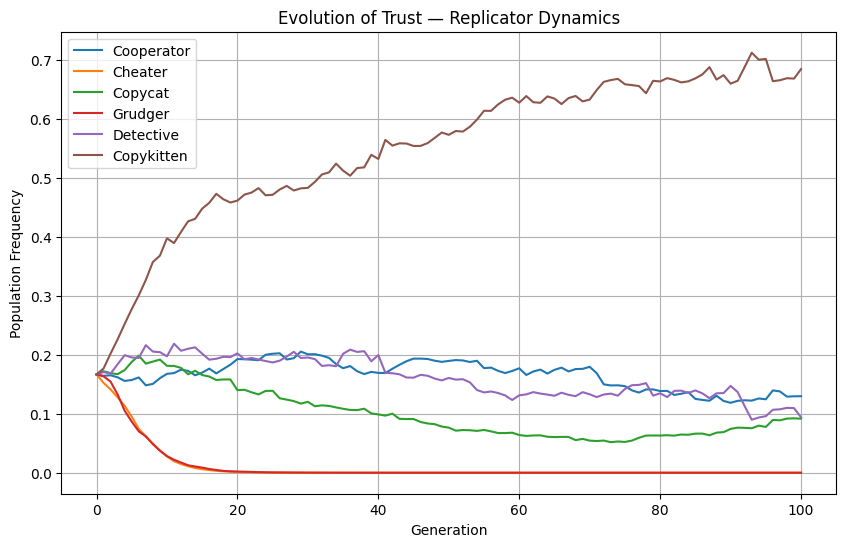

In [9]:
# -----------------------------
# RUN THE EVOLUTION SIMULATION
# -----------------------------
if __name__ == "__main__":
    strategies = [
        Cooperator(),
        Cheater(),
        Copycat(),
        Grudger(),
        Detective(),
        Copykitten()
    ]

    history, names = evolve(
        strategies,
        generations=100,
        noise=0.05,
        rounds=100
    )

    # Plot population over time
    plt.figure(figsize=(10,6))
    for i, name in enumerate(names):
        plt.plot(history[:, i], label=name)
    plt.title("Evolution of Trust — Replicator Dynamics")
    plt.xlabel("Generation")
    plt.ylabel("Population Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

## noise=0.10

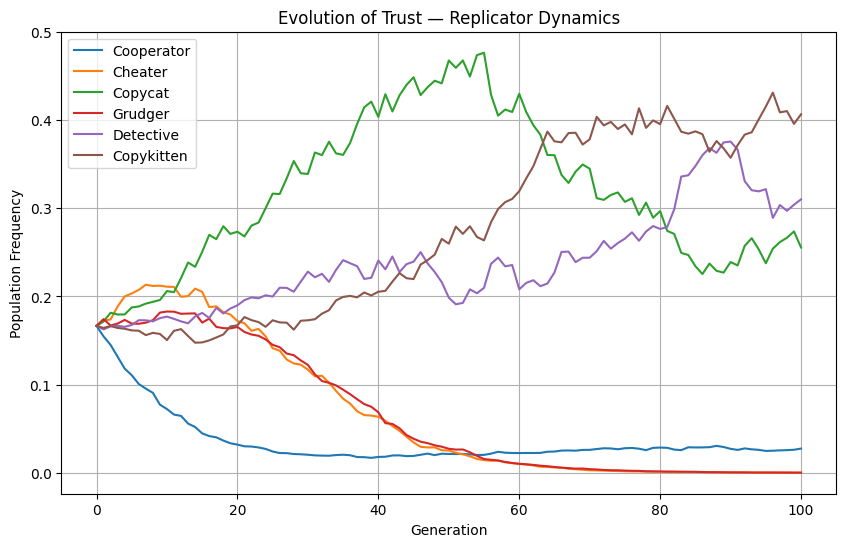

In [10]:
# -----------------------------
# RUN THE EVOLUTION SIMULATION
# -----------------------------
if __name__ == "__main__":
    strategies = [
        Cooperator(),
        Cheater(),
        Copycat(),
        Grudger(),
        Detective(),
        Copykitten()
    ]

    history, names = evolve(
        strategies,
        generations=100,
        noise=0.20,
        rounds=100
    )

    # Plot population over time
    plt.figure(figsize=(10,6))
    for i, name in enumerate(names):
        plt.plot(history[:, i], label=name)
    plt.title("Evolution of Trust — Replicator Dynamics")
    plt.xlabel("Generation")
    plt.ylabel("Population Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()